In [1]:
from ultralytics import YOLO
from PIL import Image
from data_utils import extract_rectangles_from_xml
from eval_utils import mAP
import cv2
from tqdm import tqdm
import numpy as np

In [2]:
# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

In [3]:
cap = cv2.VideoCapture('../data/S03/c010/vdo.avi')
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# We only do inference on the last 75% of the video
starting_frame = int(n_frames // 4)
cap.set(cv2.CAP_PROP_POS_FRAMES, starting_frame)

frame_detections = []
for _ in tqdm(range(starting_frame, n_frames)):
    if not cap.isOpened():
        break
    ret, frame = cap.read()
    # Run model on current frame
    results = model(frame, verbose=False)

    # Save frame detections
    frame_detections.append(results[0].boxes)

100%|██████████| 1606/1606 [00:19<00:00, 81.46it/s]


In [4]:
annotation = extract_rectangles_from_xml('../data/ai_challenge_s03_c010-full_annotation.xml')
parked_cars = annotation[0]

gt_bbox = [
    [list(np.array(r).astype(int)) for r in rect]# if r not in parked_cars]
    for rect in list(annotation.values())[starting_frame:]
]

In [5]:
filtered_predictions = [[box.xyxy[0].tolist()+box.conf.tolist() for box in frame_boxes if box.cls == 2] for frame_boxes in frame_detections]

In [15]:
# Create video with detected bounding boxes + GT boxes
cap = cv2.VideoCapture('../data/S03/c010/vdo.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, starting_frame)
video=cv2.VideoWriter('./video_prueba.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), True)
for i in tqdm(range(n_frames-starting_frame)):
    if not cap.isOpened():
        break
    ret, frame = cap.read()
    for gt in gt_bbox[i]:
        frame = cv2.rectangle(frame, (gt[0], gt[1]), (gt[2], gt[3]), (0, 255, 0), 3)

    for pred in filtered_predictions[i]:
        frame = cv2.rectangle(frame, (int(pred[0]), int(pred[1])), (int(pred[2]), int(pred[3])), (0, 0, 255), 2)
    video.write(frame)

video.release()

100%|██████████| 1606/1606 [00:17<00:00, 89.31it/s]


In [7]:
from sort import Sort
from __future__ import print_function
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
%matplotlib inline
from IPython import display as dp
import numpy as np
from skimage import io
import os
import time
%load_ext autoreload
%autoreload 2

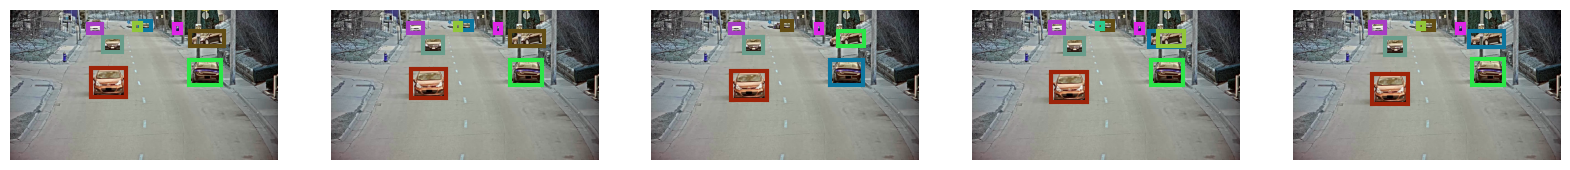

In [28]:
# este codigo solo es una prueba para plotear

colors = np.random.rand(32,3) #used only for display

f, axarr = plt.subplots(1, 5,figsize=(20,20))

cap = cv2.VideoCapture('../data/S03/c010/vdo.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, starting_frame)

for i in range(0, 5):
    ret, frame = cap.read()
    dets = filtered_predictions[i] #[x1,y1,x2,y2,score]
    axarr[i].imshow(frame)
    axarr[i].axis('off')

    for j in range(np.shape(dets)[0]):
        color = colors[j]
        coords = (dets[j][0],dets[j][1]), dets[j][2]-dets[j][0], dets[j][3]-dets[j][1]
        axarr[i].add_patch(plt.Rectangle(*coords,fill=False,edgecolor=color,lw=3))

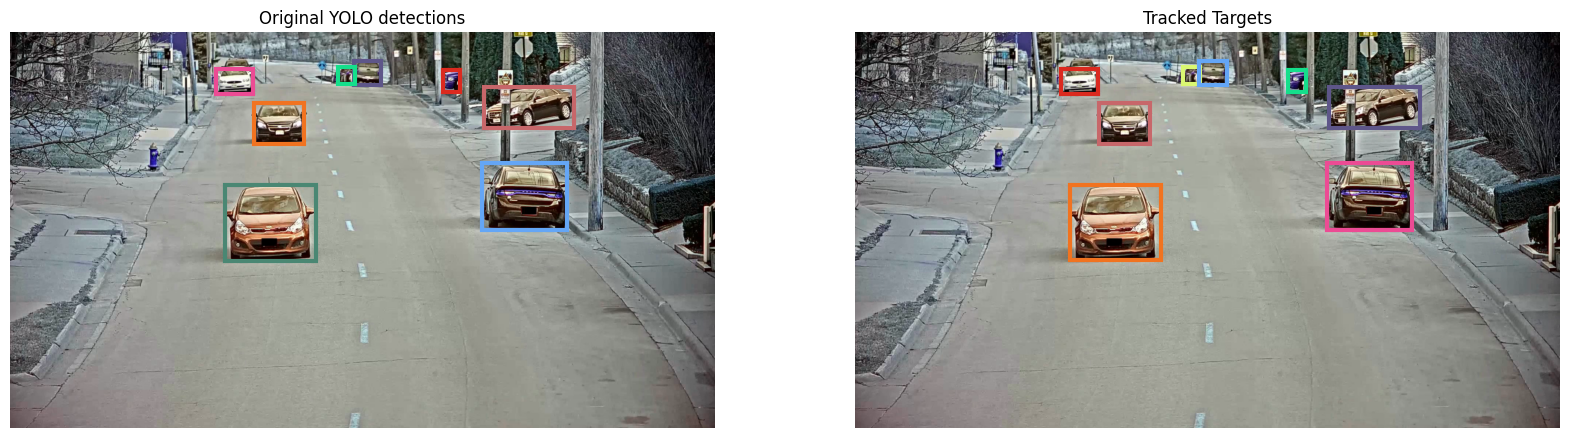

  0%|          | 1/2141 [00:00<16:12,  2.20it/s]

matched [] unmatched_dets [0 0] unmatched_trks [1 1]
t 0 [<sort.KalmanBoxTracker object at 0x7fa02bafa3a0>, <sort.KalmanBoxTracker object at 0x7fa02bafa220>, <sort.KalmanBoxTracker object at 0x7f9f614df2e0>, <sort.KalmanBoxTracker object at 0x7fa02bafa130>, <sort.KalmanBoxTracker object at 0x7fa02bafa1f0>, <sort.KalmanBoxTracker object at 0x7fa02bafa1c0>, <sort.KalmanBoxTracker object at 0x7fa02bafae50>, <sort.KalmanBoxTracker object at 0x7fa02bafaee0>]


IndexError: index 0 is out of bounds for axis 0 with size 0

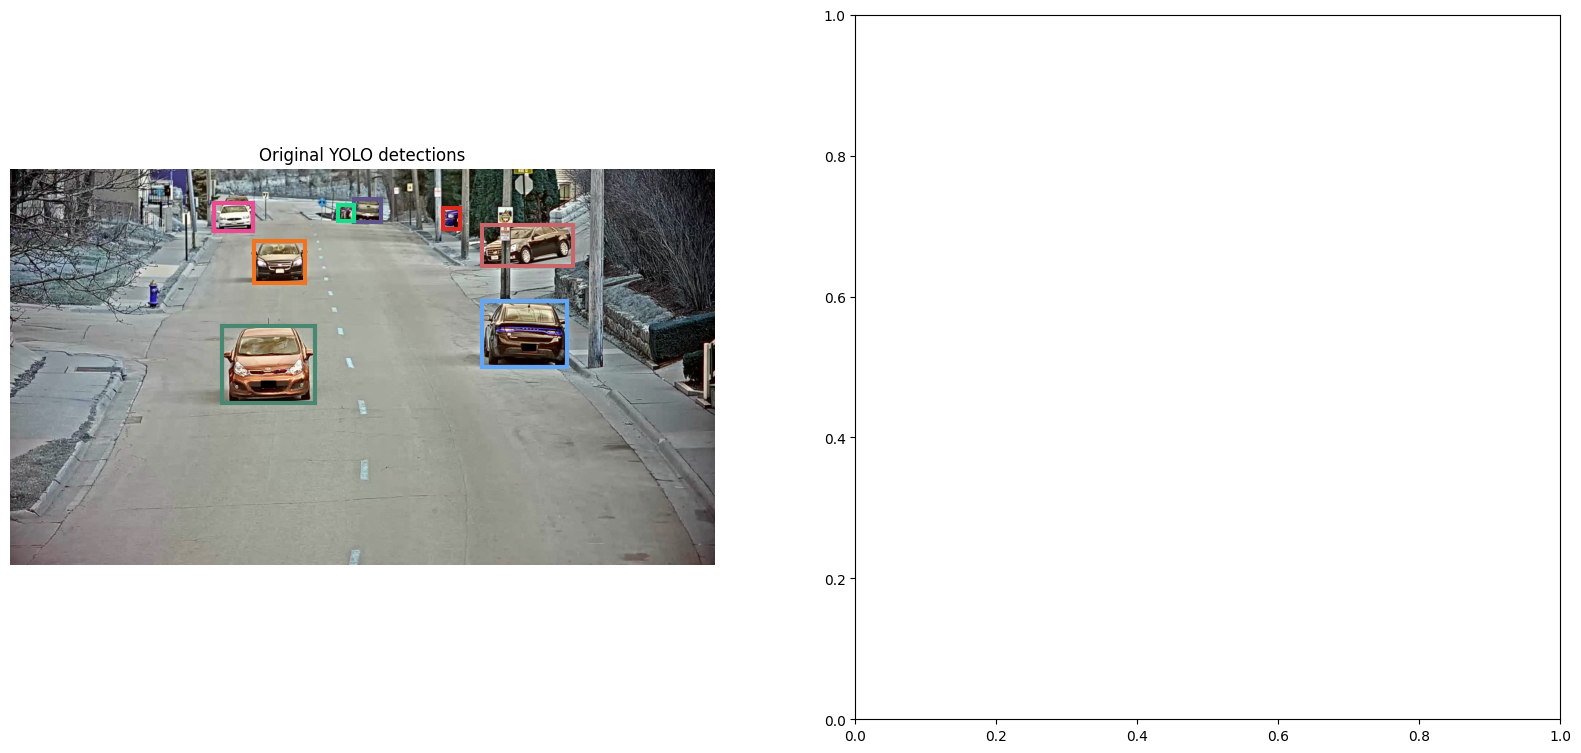

In [13]:
cap = cv2.VideoCapture('../data/S03/c010/vdo.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, starting_frame)
colors = np.random.rand(32,3) #used only for display

mot_tracker = Sort()
plt.ion() # for iterative display
fig, ax = plt.subplots(1, 2,figsize=(20,20))
for i in tqdm(range(0, n_frames)):
    ret, frame = cap.read()
    dets = filtered_predictions[i] #[x1,y1,x2,y2,score]
    ax[0].imshow(frame)
    ax[0].axis('off')
    ax[0].set_title('Original YOLO detections')
    for j in range(np.shape(dets)[0]):
        color = colors[j]
        coords = (dets[j][0],dets[j][1]), dets[j][2]-dets[j][0], dets[j][3]-dets[j][1]
        ax[0].add_patch(plt.Rectangle(*coords,fill=False,edgecolor=color,lw=3))
    
    dets = np.array(dets, dtype=np.int32)
    trackers = mot_tracker.update(dets)
    print(trackers)

    ax[1].imshow(frame)
    ax[1].axis('off')
    ax[1].set_title('Tracked Targets')
    for d in trackers:
        d = d.astype(np.uint32)
        ax[1].add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colors[d[4]%32,:]))
        #ax[1].set_adjustable('box-forced')


    dp.clear_output(wait=True)
    dp.display(plt.gcf())
    time.sleep(0.000001)
    ax[0].cla()
    ax[1].cla()
    
